### Прогнозирование возраста морского ушка на основе физических измерений.

Возраст морского ушка определяется путем разрезания оболочки через конус, ее окрашивания и подсчета количества колец через микроскоп - скучная и трудоемкая задача.  Другие измерения, которые легче получить, используются для прогнозирования возраста.  Для решения этой задачи может потребоваться дополнительная информация, например, о погодных условиях и местоположении (отсюда и наличие продовольствия).


Дано имя атрибута, тип атрибута, единица измерения и
краткое описание. Количество колец - это значение для прогнозирования: либо
как непрерывное значение или как проблема классификации.

| Название | Тип данных | Измер. | Описание |
|---------|----------|------------|----|
| Пол | именной | - | M, F и I (младенец)
| Длина | непрерывная | мм. | Самое длинное измерение раковины
| Диаметр | непрерывного | мм. | перпендикулярно длине
| Высота | непрерывного | мм. | с мясом в скорлупе
| Общий вес | непрерывного | граммы | всего ушка
| Перемешанный вес | непрерывного | граммы | веса мяса
| Вес внутренностей | непрерывный | граммы | веса кишечника (после кровотечения)
| Вес скорлупы | непрерывный | граммы  | после сушки
| Кольца | целые | - | +1,5 дает возраст в годах

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, AdaBoostRegressor

In [2]:
data_path = './data/abalone.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

Sex  Length  Diameter  Height   Whole  Shucked  Viscera  Shell  Rings
0   M   0.455     0.365   0.095  0.5140   0.2245   0.1010  0.150     15
1   M   0.350     0.265   0.090  0.2255   0.0995   0.0485  0.070      7
2   F   0.530     0.420   0.135  0.6770   0.2565   0.1415  0.210      9
3   M   0.440     0.365   0.125  0.5160   0.2155   0.1140  0.155     10
4   I   0.330     0.255   0.080  0.2050   0.0895   0.0395  0.055      7

На основе интуитивных соображений.

Размеры самок обычно наибольшие в популяции, далее за ними идут самцы (тк им нет необходимости создавать потомство), после самцов меньше обычно подрастающее поколение.

На основе этой догадки преобразуем класс Пол в цифровое значени

In [5]:
def sex_transform(s):
    s2n_map = {
        "M": 0.5,
        "F": 1,
        "I": 0
    }
    return s2n_map[s]

df.Sex = df.Sex.transform(sex_transform)

In [6]:
df.head()

Sex  Length  Diameter  Height   Whole  Shucked  Viscera  Shell  Rings
0  0.5   0.455     0.365   0.095  0.5140   0.2245   0.1010  0.150     15
1  0.5   0.350     0.265   0.090  0.2255   0.0995   0.0485  0.070      7
2  1.0   0.530     0.420   0.135  0.6770   0.2565   0.1415  0.210      9
3  0.5   0.440     0.365   0.125  0.5160   0.2155   0.1140  0.155     10
4  0.0   0.330     0.255   0.080  0.2050   0.0895   0.0395  0.055      7

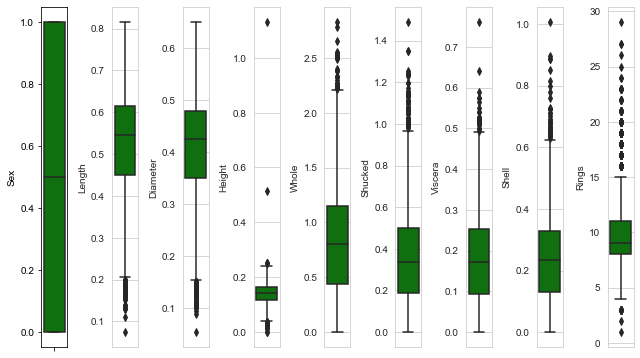

In [7]:
l = df.columns.values
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()

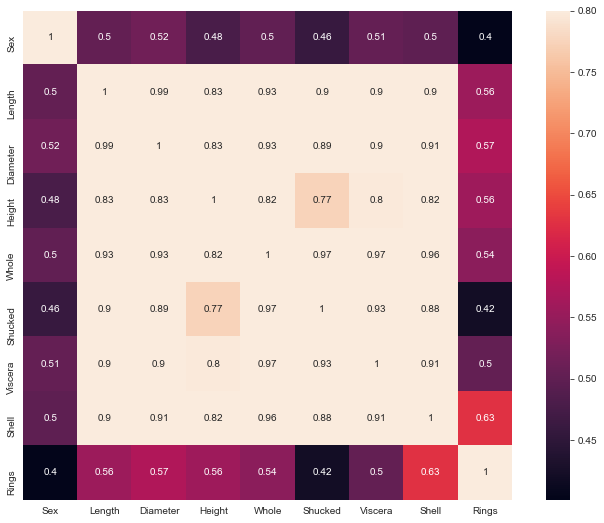

In [8]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

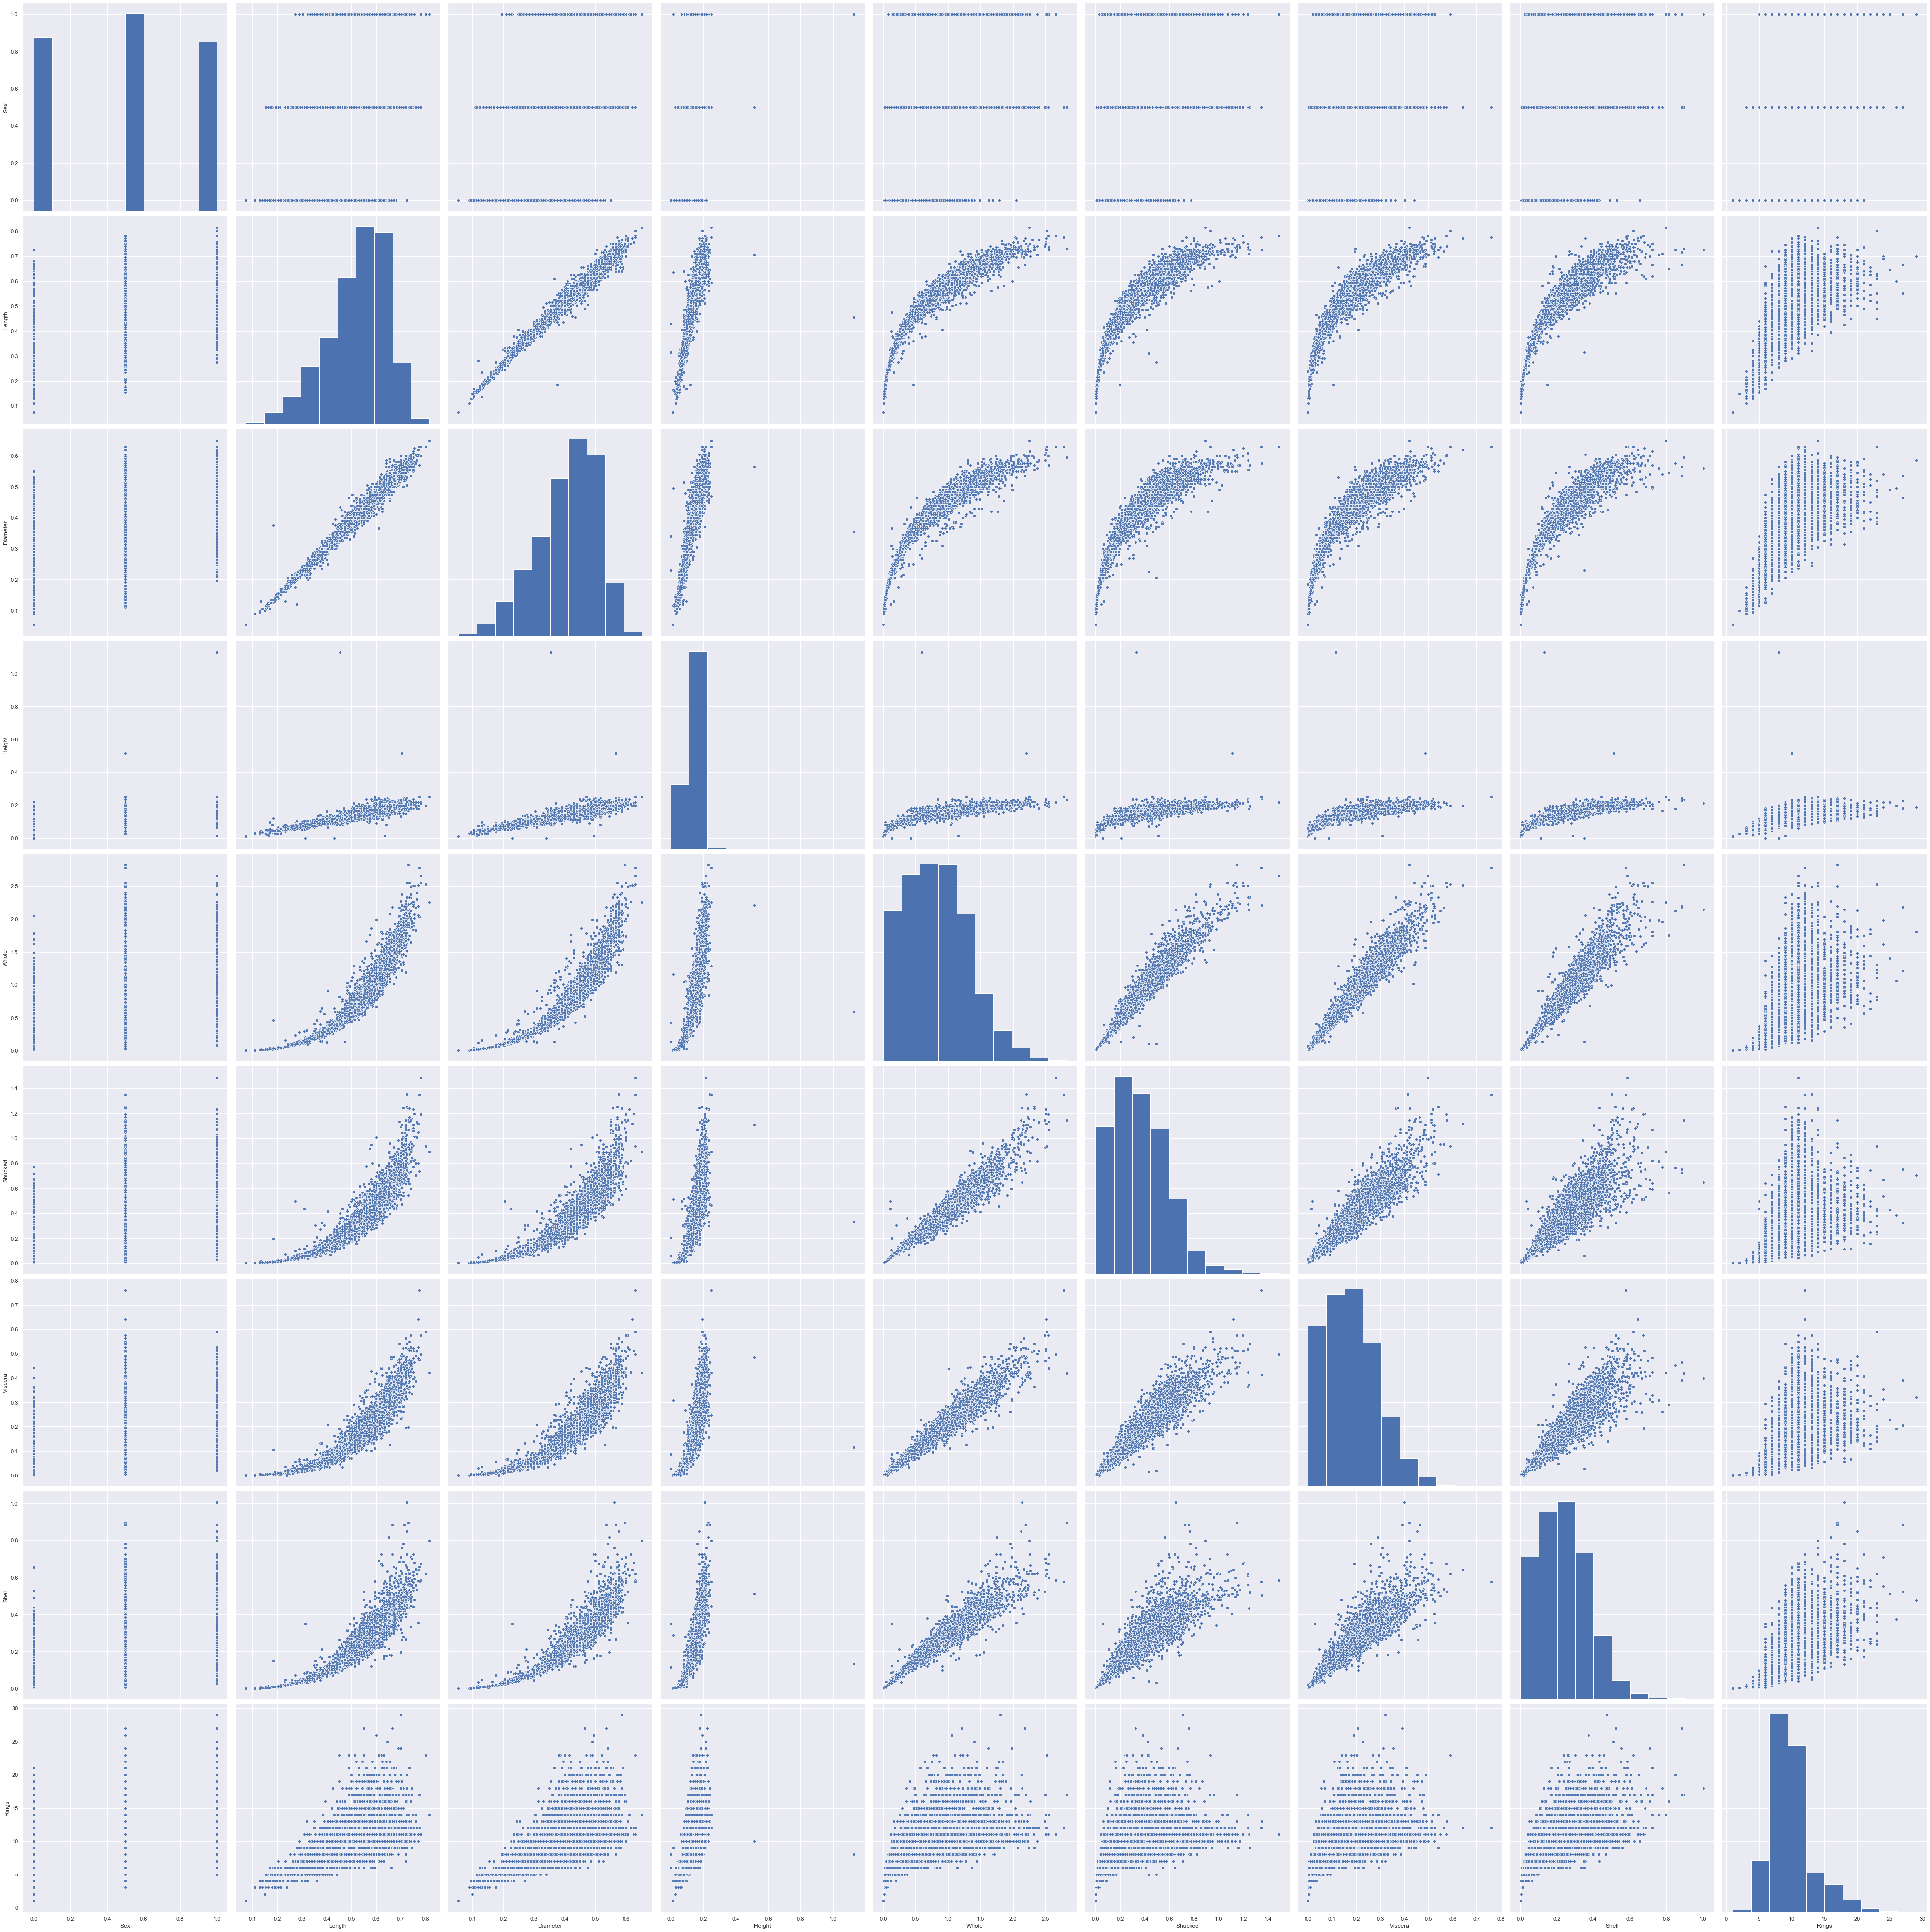

In [9]:
sns.set()
sns.pairplot(df, height = 6)
plt.show();

(картинка генерится качественная нужно просто просмотреть не через ноутбук)

Из графиков выше видно что между почти всеми параметрами прослеживается кореляция. Так же оказалась верна наша догадка насчет пола и их числовых эквивалентов.

Попробуем избавить данные от избыточности.

1. Диаметр, тк линейно зависит от длины
2. Высота, тк линейно зависит от длины

In [10]:
df.drop(['Diameter', 'Height'], axis=1, inplace=True)

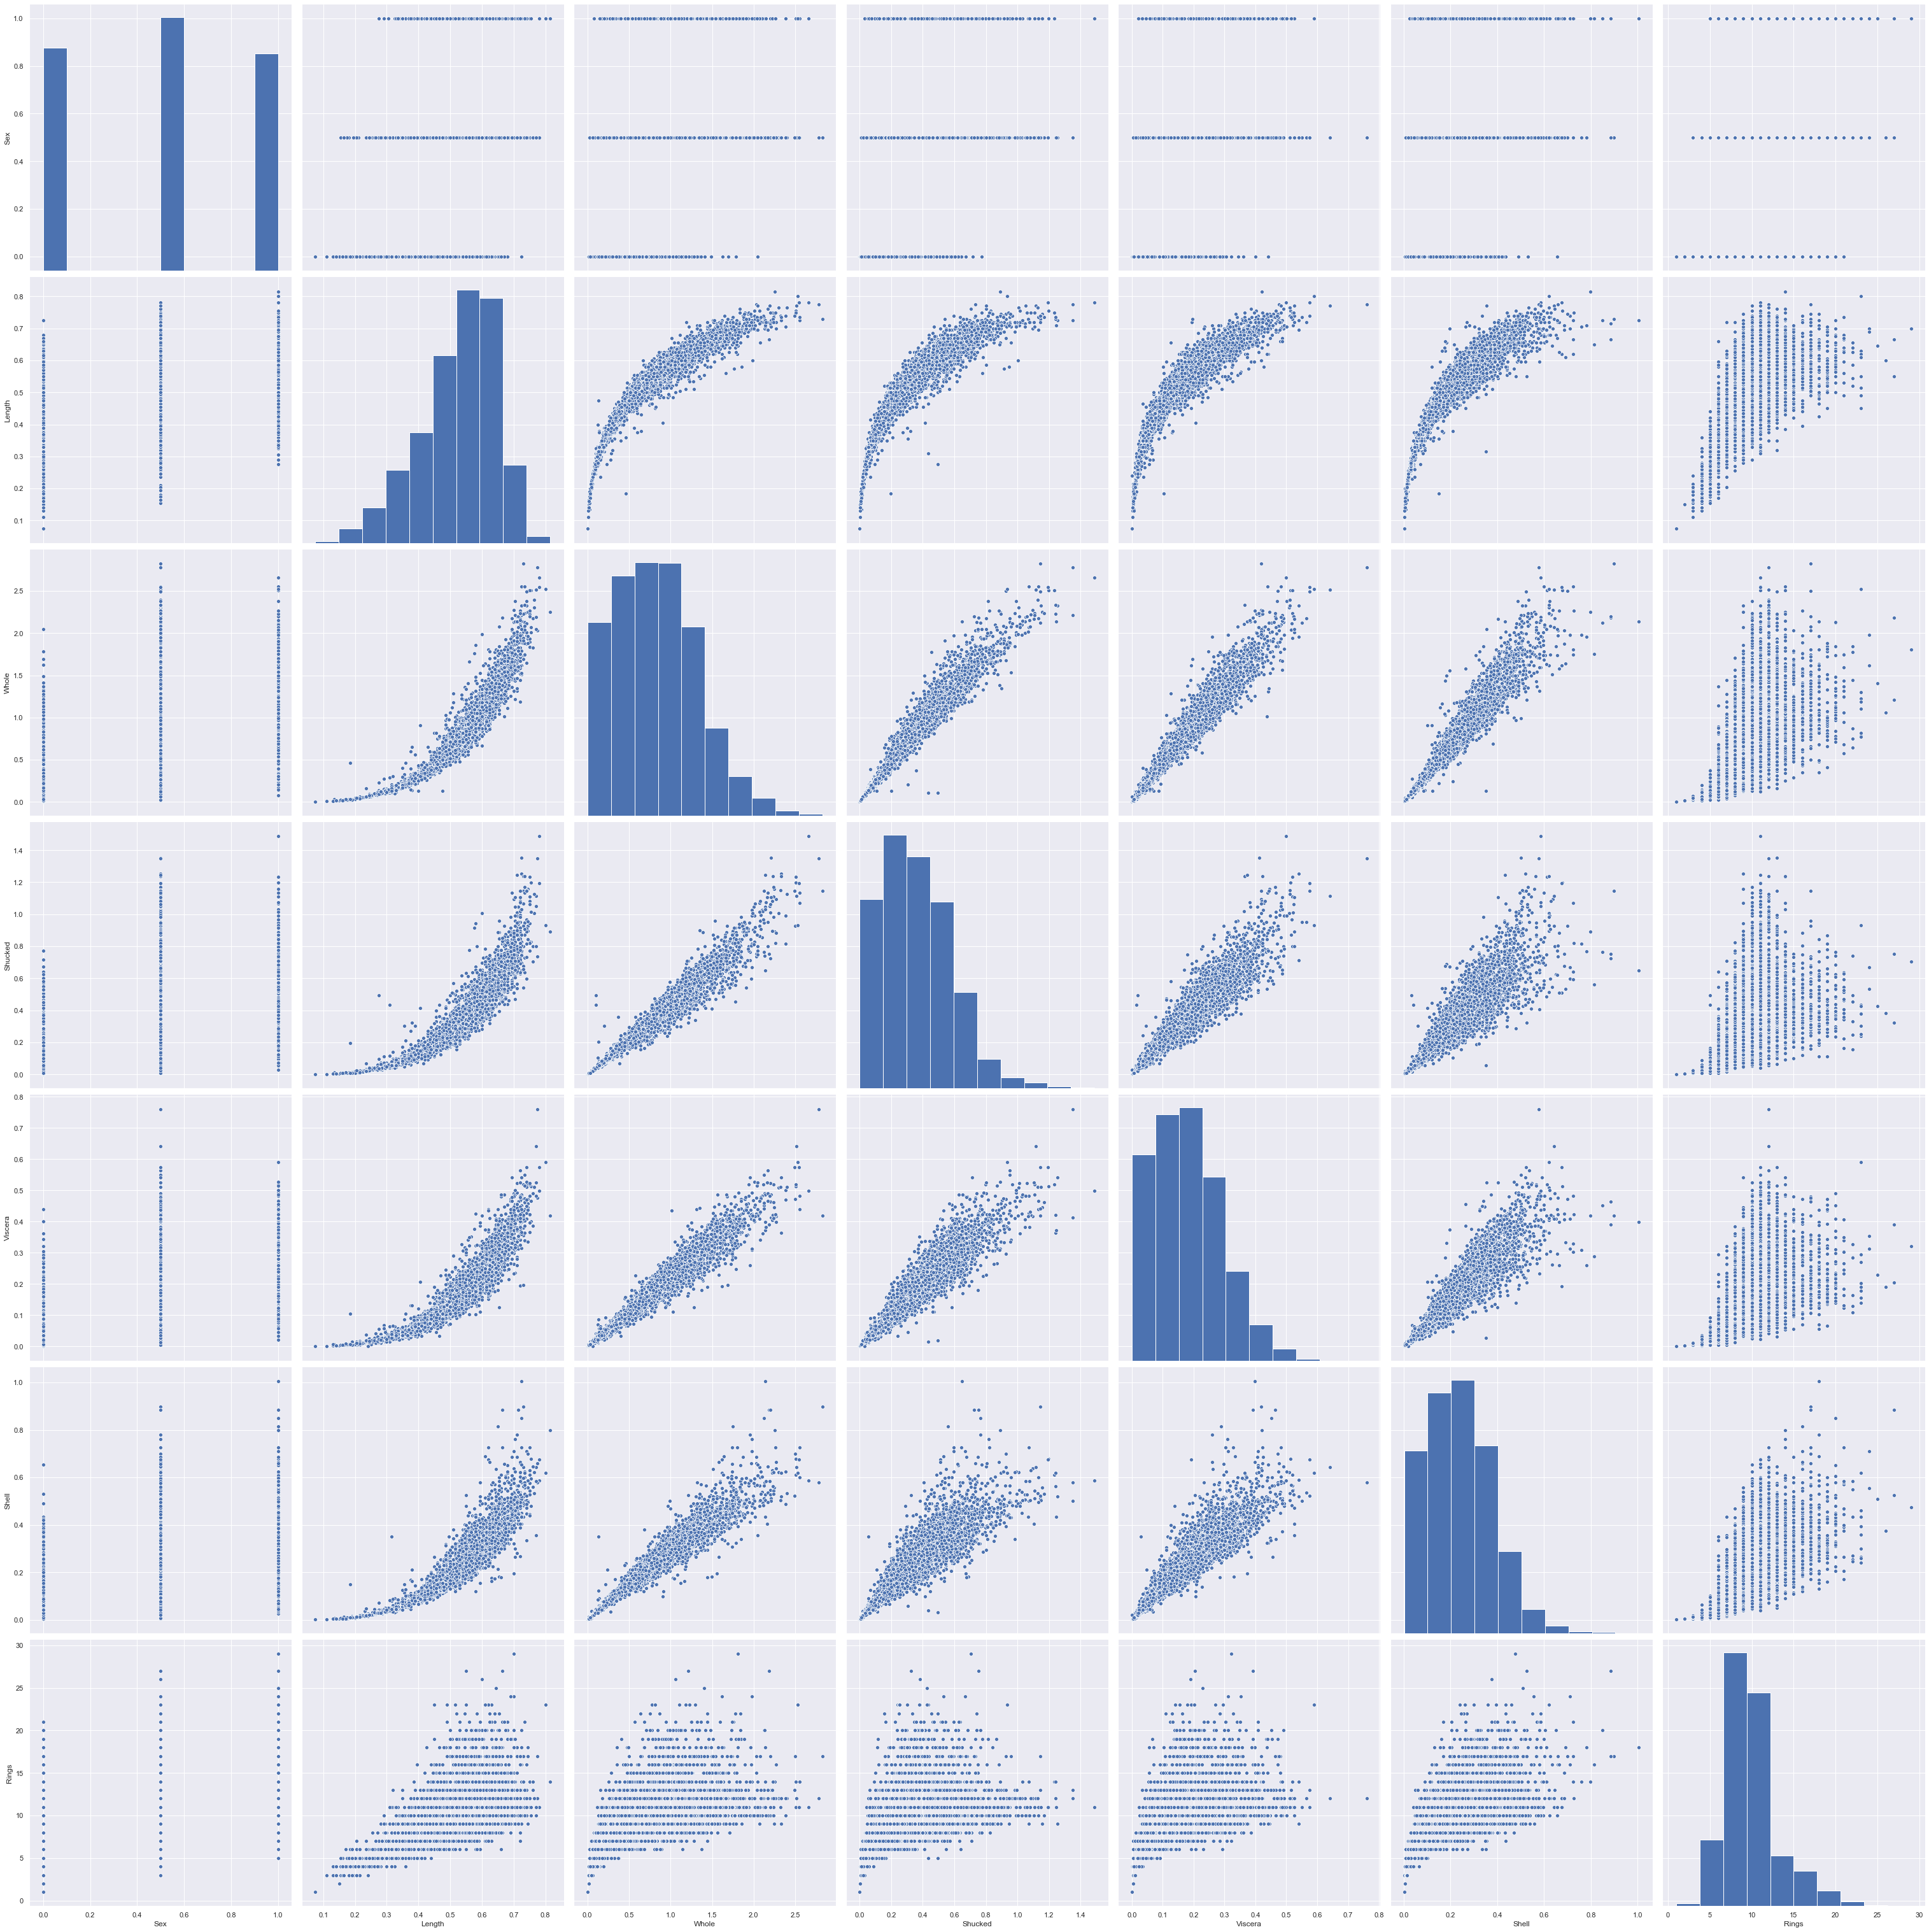

In [11]:
sns.set()
sns.pairplot(df, height = 6)
plt.show();

In [12]:
X_data, Y_data = df.loc[:,:"Shell"], df["Rings"]

X_train,  X_test,  y_train,  y_test =  train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )
splited_data = [X_train, y_train, X_test, y_test]

In [13]:
def test_model(train_X, train_y, test_X, test_y, model, params=[{}], sep='', show_params=True):
    for param in params:
        test_model = model(**param)
        test_model.fit(train_X, train_y)
        if params != [{}] and show_params:
            print("Параметры:", param)
        print("Оценка:", mean_absolute_error(test_model.predict(test_X).astype(int), test_y))
        print(end=sep)

In [14]:
test_model(X_train, y_train, X_test, y_test, LinearRegression)

Оценка: 1.563397129186603


В нашем случае мы видим что наша модель не очень точна. Если снова взглянуть на графики то появляется предположение что в данном случае нам поможет полином второй степени.

In [15]:
poly = PolynomialFeatures(degree = 2)

test_model(poly.fit_transform(X_train), y_train, poly.transform(X_test), y_test, LinearRegression)

Оценка: 1.5047846889952152


Результат практически не изменился - пришло время нейронок (нет)

Мы предполагаем что наша задача так же является задачей классификации, и тестируем различные её варианты

In [16]:
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}, 
    {'kernel': 'sigmoid', 'gamma':'auto'}]

test_model(X_train, y_train, X_test, y_test, SVC, params=params)

Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 1.8504784688995215
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 2.1088516746411483
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 1.9090909090909092
Параметры: {'kernel': 'sigmoid', 'gamma': 'auto'}
Оценка: 1.9198564593301435


Возможно я где-то накосячил с параметрами, но результат хуже чем с линейной регрессией 

In [17]:
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}]

test_model(X_train, y_train, X_test, y_test, SVR, params=params)

Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 1.6531100478468899
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 1.8157894736842106
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 1.645933014354067


In [18]:
params = [
    {'C':1.0, 'max_iter':10000}, 
    {'C':5.0, 'max_iter':10000}, 
    {'C':125.0, 'max_iter':10000},
    {'C':625.0, 'max_iter':10000},
    {'C':2500.0, 'max_iter':10000},
    {'C':12500.0, 'max_iter':10000},
    {'C':62500.0, 'max_iter':10000},]

test_model(X_train, y_train, X_test, y_test, LinearSVR, params=params)

Параметры: {'C': 1.0, 'max_iter': 10000}
Оценка: 1.6543062200956937
Параметры: {'C': 5.0, 'max_iter': 10000}
Оценка: 1.6136363636363635


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Параметры: {'C': 125.0, 'max_iter': 10000}
Оценка: 1.5944976076555024


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Параметры: {'C': 625.0, 'max_iter': 10000}
Оценка: 1.6232057416267942


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Параметры: {'C': 2500.0, 'max_iter': 10000}
Оценка: 1.763157894736842


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Параметры: {'C': 12500.0, 'max_iter': 10000}
Оценка: 1.895933014354067
Параметры: {'C': 62500.0, 'max_iter': 10000}
Оценка: 1.7344497607655502


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [19]:
params = [{'nu':x, 'gamma':'auto'} for x in [.01,.1,.2,.3,.4,.5,.6,.8,1.0]]

test_model(X_train, y_train, X_test, y_test, NuSVR, params=params)

Параметры: {'nu': 0.01, 'gamma': 'auto'}
Оценка: 3.492822966507177
Параметры: {'nu': 0.1, 'gamma': 'auto'}
Оценка: 2.1339712918660285
Параметры: {'nu': 0.2, 'gamma': 'auto'}
Оценка: 1.708133971291866
Параметры: {'nu': 0.3, 'gamma': 'auto'}
Оценка: 1.6196172248803828
Параметры: {'nu': 0.4, 'gamma': 'auto'}
Оценка: 1.5801435406698565
Параметры: {'nu': 0.5, 'gamma': 'auto'}
Оценка: 1.6028708133971292
Параметры: {'nu': 0.6, 'gamma': 'auto'}
Оценка: 1.6220095693779903
Параметры: {'nu': 0.8, 'gamma': 'auto'}
Оценка: 1.638755980861244
Параметры: {'nu': 1.0, 'gamma': 'auto'}
Оценка: 1.645933014354067


Для решения задач класификации также отлично подходят деревья

In [20]:
params = [{"max_depth":x} for x in range(1,10)]
test_model(*splited_data, tree.DecisionTreeRegressor, params)

Параметры: {'max_depth': 1}
Оценка: 2.0334928229665072
Параметры: {'max_depth': 2}
Оценка: 1.80622009569378
Параметры: {'max_depth': 3}
Оценка: 1.7476076555023923
Параметры: {'max_depth': 4}
Оценка: 1.6423444976076556
Параметры: {'max_depth': 5}
Оценка: 1.5657894736842106
Параметры: {'max_depth': 6}
Оценка: 1.5777511961722488
Параметры: {'max_depth': 7}
Оценка: 1.5645933014354068
Параметры: {'max_depth': 8}
Оценка: 1.5849282296650717
Параметры: {'max_depth': 9}
Оценка: 1.6770334928229664


In [21]:
params = [{'random_state':42, "n_estimators":x} for x in (
    list(range(1,10,2)) + list(range(10,100,20)) + list(range(100,900,100)))
]
test_model(*splited_data, GradientBoostingRegressor, params)

Параметры: {'random_state': 42, 'n_estimators': 1}
Оценка: 2.1303827751196174
Параметры: {'random_state': 42, 'n_estimators': 3}
Оценка: 2.0514354066985647
Параметры: {'random_state': 42, 'n_estimators': 5}
Оценка: 1.9090909090909092
Параметры: {'random_state': 42, 'n_estimators': 7}
Оценка: 1.8600478468899522
Параметры: {'random_state': 42, 'n_estimators': 9}
Оценка: 1.7715311004784688
Параметры: {'random_state': 42, 'n_estimators': 10}
Оценка: 1.7380382775119618
Параметры: {'random_state': 42, 'n_estimators': 30}
Оценка: 1.5287081339712918
Параметры: {'random_state': 42, 'n_estimators': 50}
Оценка: 1.5167464114832536
Параметры: {'random_state': 42, 'n_estimators': 70}
Оценка: 1.5215311004784688
Параметры: {'random_state': 42, 'n_estimators': 90}
Оценка: 1.5239234449760766
Параметры: {'random_state': 42, 'n_estimators': 100}
Оценка: 1.5370813397129186
Параметры: {'random_state': 42, 'n_estimators': 200}
Оценка: 1.5478468899521531
Параметры: {'random_state': 42, 'n_estimators': 300}
Оц

In [22]:
params = [{'random_state':42, "n_estimators":x} for x in (
    list(range(1,10,2)) + list(range(10,100,20)) + list(range(100,500,100)))
]

test_model(*splited_data, RandomForestRegressor, params)

Параметры: {'random_state': 42, 'n_estimators': 1}
Оценка: 2.1052631578947367
Параметры: {'random_state': 42, 'n_estimators': 3}
Оценка: 1.7212918660287082
Параметры: {'random_state': 42, 'n_estimators': 5}
Оценка: 1.6830143540669857
Параметры: {'random_state': 42, 'n_estimators': 7}
Оценка: 1.6327751196172249
Параметры: {'random_state': 42, 'n_estimators': 9}
Оценка: 1.611244019138756
Параметры: {'random_state': 42, 'n_estimators': 10}
Оценка: 1.6196172248803828
Параметры: {'random_state': 42, 'n_estimators': 30}
Оценка: 1.562200956937799
Параметры: {'random_state': 42, 'n_estimators': 50}
Оценка: 1.5454545454545454
Параметры: {'random_state': 42, 'n_estimators': 70}
Оценка: 1.5502392344497609
Параметры: {'random_state': 42, 'n_estimators': 90}
Оценка: 1.5311004784688995
Параметры: {'random_state': 42, 'n_estimators': 100}
Оценка: 1.5442583732057416
Параметры: {'random_state': 42, 'n_estimators': 200}
Оценка: 1.5370813397129186
Параметры: {'random_state': 42, 'n_estimators': 300}
Оцен

In [23]:
params = [{'random_state':42, "n_estimators":x} for x in (
    list(range(1,10,2)) + list(range(10,100,20)) + [100, 200])
]
test_model(*splited_data, AdaBoostRegressor, params)

Параметры: {'random_state': 42, 'n_estimators': 1}
Оценка: 1.7069377990430623
Параметры: {'random_state': 42, 'n_estimators': 3}
Оценка: 1.638755980861244
Параметры: {'random_state': 42, 'n_estimators': 5}
Оценка: 1.6818181818181819
Параметры: {'random_state': 42, 'n_estimators': 7}
Оценка: 1.6818181818181819
Параметры: {'random_state': 42, 'n_estimators': 9}
Оценка: 1.7404306220095693
Параметры: {'random_state': 42, 'n_estimators': 10}
Оценка: 1.812200956937799
Параметры: {'random_state': 42, 'n_estimators': 30}
Оценка: 2.1160287081339715
Параметры: {'random_state': 42, 'n_estimators': 50}
Оценка: 2.199760765550239
Параметры: {'random_state': 42, 'n_estimators': 70}
Оценка: 2.199760765550239
Параметры: {'random_state': 42, 'n_estimators': 90}
Оценка: 2.199760765550239
Параметры: {'random_state': 42, 'n_estimators': 100}
Оценка: 2.199760765550239
Параметры: {'random_state': 42, 'n_estimators': 200}
Оценка: 2.199760765550239


In [24]:
m1 = GradientBoostingRegressor(random_state = 42, n_estimators=95)
m2 = RandomForestRegressor(random_state = 42, n_estimators=300)
m3 = LinearRegression()
params = [
    {'estimators':[('gb', m1), ('rf', m2), ('lr', m3)]},
    {'estimators':[('gb', m1), ('rf', m2)]},
    {'estimators':[('gb', m1), ('lr', m3)]},
    {'estimators':[('rf', m2), ('lr', m3)]}
]

test_model(*splited_data, VotingRegressor, params, sep="\n\n", show_params=False)

Оценка: 1.4808612440191387


Оценка: 1.505980861244019


Оценка: 1.5035885167464116


Оценка: 1.4808612440191387




Теперь можно попробовать и нейросети

Далее все строится только на моих предположениях о том как выглядит функция в реале и интуиции

In [25]:
import tensorflow as tf
import tensorflow.keras as keras
import datetime

In [26]:
# один из вариантов моделей
# model = keras.models.Sequential([
#     keras.layers.InputLayer(X_train.shape[1]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(25, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(20, activation='relu'),
#     keras.layers.Dense(1)
# ])

In [32]:
model = keras.models.Sequential([
    keras.layers.InputLayer(X_train.shape[1]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(90, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(45, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(40, activation='sigmoid'),
    keras.layers.Dense(1)
])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 90)                630       
_________________________________________________________________
dropout_2 (Dropout)          (None, 90)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 90)                360       
_________________________________________________________________
dense_6 (Dense)              (None, 45)                4095      
_________________________________________________________________
dropout_3 (Dropout)          (None, 45)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 45)               

In [34]:
model.compile(optimizer='adam',
                        loss='mean_absolute_error',
                        metrics=['mae'])

In [35]:
model.fit(X_train, y_train, batch_size=70, epochs=40, callbacks=[
    keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=5, verbose=0, mode="min"),
])

Epoch 1/50
48/48 [==============================] - 0s 8ms/step - loss: 9.2945 - mae: 9.2945
Epoch 2/50
48/48 [==============================] - 0s 7ms/step - loss: 7.9691 - mae: 7.9691
Epoch 3/50
48/48 [==============================] - 0s 7ms/step - loss: 6.3473 - mae: 6.3473
Epoch 4/50
48/48 [==============================] - 0s 7ms/step - loss: 4.4373 - mae: 4.4373
Epoch 5/50
48/48 [==============================] - 0s 7ms/step - loss: 2.9033 - mae: 2.9033
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: 2.1527 - mae: 2.1527
Epoch 7/50
48/48 [==============================] - 0s 7ms/step - loss: 1.9516 - mae: 1.9516
Epoch 8/50
48/48 [==============================] - 0s 7ms/step - loss: 1.8362 - mae: 1.8362A: 0s - loss: 1.8434 - mae: 1.
Epoch 9/50
48/48 [==============================] - 0s 7ms/step - loss: 1.7846 - mae: 1.7846
Epoch 10/50
48/48 [==============================] - 0s 7ms/step - loss: 1.7516 - mae: 1.7516
Epoch 11/50
48/48 [====================

In [36]:
print("Оценка:", mean_absolute_error(model.predict(X_test), y_test))

Оценка: 1.4676836937238156


Наилучший результат